In [ ]:
import json, os, sys, math
from itertools import combinations

# from utils import *

import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [4]:
with open('../rawdata/msd_subset_audio_features.json', 'r') as f:
    merged_features_raw = json.load(f)

with open('../rawdata/msd_taste_profile_no-lyrics.json', 'r') as f:
    taste_profile_raw = json.load(f)

In [5]:
len(merged_features_raw), len(taste_profile_raw)

(10000, 404103)

In [6]:
# Normalize content features to [0, 1]
max_features = {
    'duration': -np.inf,
    'key': -np.inf,
    'key_confidence': -np.inf,
    'mode': -np.inf,
    'mode_confidence': -np.inf,
    'loudness': -np.inf,
    'tempo': -np.inf,
    'time_signature': -np.inf,
    'time_signature_confidence': -np.inf,
}

min_features = {
    'duration': np.inf,
    'key': np.inf,
    'key_confidence': np.inf,
    'mode': np.inf,
    'mode_confidence': np.inf,
    'loudness': np.inf,
    'tempo': np.inf,
    'time_signature': np.inf,
    'time_signature_confidence': np.inf,
}

for _, features in merged_features_raw.items():
    for feature, value in features.items():
        if feature in max_features:
            max_features[feature] = max(max_features[feature], value)
            min_features[feature] = min(min_features[feature], value)
            
max_features, min_features

({'duration': 1819.76771,
  'key': 11.0,
  'key_confidence': 1.0,
  'mode': 1.0,
  'mode_confidence': 1.0,
  'loudness': 0.566,
  'tempo': 262.828,
  'time_signature': 7.0,
  'time_signature_confidence': 1.0},
 {'duration': 1.04444,
  'key': 0.0,
  'key_confidence': 0.0,
  'mode': 0.0,
  'mode_confidence': 0.0,
  'loudness': -51.643,
  'tempo': 0.0,
  'time_signature': 0.0,
  'time_signature_confidence': 0.0})

In [7]:
def process_features(features):
    # Filter out unrecognized features
    feature_subset = { feature_name: features[feature_name] for feature_name in max_features }
    
    # Normalize recognized features
    for feature, value in feature_subset.items():
        if feature in max_features:
            feature_subset[feature] = (value - min_features[feature]) / (max_features[feature] - min_features[feature])
            
    return feature_subset

In [8]:
merged_features_processed = { track_id: process_features(features) for track_id, features in merged_features_raw.items() }

In [9]:
average_user_profiles = {}
user_setlists = {}

for user_id, tracklist in taste_profile_raw.items():
    initial = {
        'duration': 0,
        'key': 0,
        'key_confidence': 0,
        'mode': 0,
        'mode_confidence': 0,
        'loudness': 0,
        'tempo': 0,
        'time_signature': 0,
        'time_signature_confidence': 0,
    }
    user_setlists[user_id] = {}
    
    # Generate weighted average of features  
    total_track_counts = 0
    
    for track in tracklist:
        track_id, count = track['track'], track['count']
        if track_id not in merged_features_processed:
            raise 'AAAAA'
        
        total_track_counts += count
        user_setlists[user_id][track_id] = count
        
        track_features = merged_features_processed[track_id]
        for feature, value in track_features.items():
            initial[feature] += value * count
            
    for feature in initial:
        initial[feature] /= total_track_counts
    
    average_user_profiles[user_id] = initial

len(average_user_profiles)

404103

In [10]:
def dict_euclidean_distance(a, b):
    return np.linalg.norm(np.array(list(a.values())) - np.array(list(b.values())))

def dict_manhtattan_distance(a, b):
    return np.sum(np.abs(np.array(list(a.values())) - np.array(list(b.values()))))

# Define a user's rating of a track as the number of times they listened to it
# If they haven't listened to it, define rating as the similarity (i.e. inverse distance) between the user's average profile and the track's features
def user_rating(user_id, track_id, distance_func: callable=dict_euclidean_distance):
    if track_id in user_setlists[user_id]:
        return user_setlists[user_id][track_id]
    else:
        user_avg_features = average_user_profiles[user_id]
        track_features = merged_features_processed[track_id]
        
        return 1 / (1 + distance_func(user_avg_features, track_features))        

In [11]:
def pearson_user_sim(user_id1, user_id2):
    combined_songs = set([*user_setlists[user_id1].keys(), *user_setlists[user_id2].keys()])
    n_songs = len(combined_songs)
    
    user1_ratings = np.zeros(n_songs)
    user2_ratings = np.zeros(n_songs)
    
    for i, song in enumerate(combined_songs):
        user1_ratings[i] = user_rating(user_id1, song)
        user2_ratings[i] = user_rating(user_id2, song)
    
    user1_ratings[:] -= np.mean(user1_ratings)
    user2_ratings[:] -= np.mean(user2_ratings)
    
    num = np.dot(user1_ratings, user2_ratings)
    den = np.linalg.norm(user1_ratings) * np.linalg.norm(user2_ratings)
    
    if num == 0 and den == 0:
        return 0
    
    return num / den

def cosine_user_sim(user_id1, user_id2):
    combined_songs = set([*user_setlists[user_id1].keys(), *user_setlists[user_id2].keys()])
    n_songs = len(combined_songs)
    
    user1_ratings = np.zeros(n_songs)
    user2_ratings = np.zeros(n_songs)
    
    for i, song in enumerate(combined_songs):
        user1_ratings[i] = user_rating(user_id1, song)
        user2_ratings[i] = user_rating(user_id2, song)
    
    num = np.dot(user1_ratings, user2_ratings)
    den = np.linalg.norm(user1_ratings) * np.linalg.norm(user2_ratings)
    
    if num == 0 and den == 0:
        return 0
    
    return num / den

In [10]:
# Generate user ID to index mapping
userid_to_index = { user_id: i for i, user_id in enumerate(average_user_profiles.keys()) }
index_to_userid = { v: k for k, v in userid_to_index.items() }

In [11]:
RAND_SEED = 916
rand = np.random.default_rng(RAND_SEED)

In [12]:
def simulate_subset(subset_size, rand, neighborhood_sizes, user_sim_func):
    # Generate random user subset
    user_subset = rand.choice(len(average_user_profiles), subset_size, replace=False)
    index_subset_mapping = { i: index_to_userid[user_id] for i, user_id in enumerate(user_subset) }
    subset_index_mapping = { v: k for k, v in index_subset_mapping.items() }
    
    print(f'Generating similarity matrix for subset of size {subset_size}...')
    user_similarity = np.full((subset_size, subset_size), -np.inf)
    total_sims = (subset_size * (subset_size - 1)) // 2

    for i, pair in enumerate(combinations(index_subset_mapping, 2)):
        if i % 2500 == 0:
            print(f'{i=}/{total_sims} | {(i/total_sims * 100):.3f}%', end='\r')
        
        user1, user2 = pair
        sim = user_sim_func(index_subset_mapping[user1], index_subset_mapping[user2])
        
        user_similarity[user1][user2] = sim
        user_similarity[user2][user1] = sim
    print()
        
    user_similarity_sorted = np.argsort(user_similarity)
    
    # Uses the similarity matrix to generate neighborhoods of size n
    # This is pretty awful code, but it'll do. Anyways, we're data scientists, not software engineers
    def run_neighborhood_analysis(neighborhood_size):
        print(f'>> Generating neighborhood of size {neighborhood_size}...')
        user_neighborhoods = {}
        
        for i, row in enumerate(user_similarity_sorted):
            user_neighborhoods[index_subset_mapping[i]] = [index_subset_mapping[n] for n in row[-neighborhood_size:]]
            
        def predict_rating(user_id, track_id):
            user_index = subset_index_mapping[user_id]
            neighborhood = user_neighborhoods[user_id]
            
            neighborhood_ratings = [user_rating(neighbor, track_id) for neighbor in neighborhood]
            
            similarities = [user_similarity[user_index][subset_index_mapping[neighbor]] for neighbor in neighborhood]
            
            num = np.dot(similarities, neighborhood_ratings)
            den = np.abs(similarities).sum()
            
            if num == 0 or den == 0:
                return 0

            return num / den
        
        squared_error = 0
        abs_error = 0
        hits = 0
        run_count = 0
        
        print(f'>> Analyzing neighborhood of size {neighborhood_size}...')
        for i, user in enumerate(user_neighborhoods):
            if i % 250 == 0:
                print(f'>> {i=}/{subset_size} | {(i/subset_size * 100):.3f}%', end='\r')
            
            for track in taste_profile_raw[user]:
                run_count += 1
                track_id = track['track']
                
                prediction = predict_rating(user, track_id)
                actual = track['count']
                
                abs_error += np.abs(prediction - actual)
                squared_error += (prediction - actual) ** 2
                
                if round(prediction) == actual:
                    hits += 1

        return user_neighborhoods, squared_error / run_count, abs_error / run_count, hits / run_count
    
    neighborhood_analysis = [run_neighborhood_analysis(n) for n in neighborhood_sizes]
    print()
    
    return user_similarity, subset_index_mapping, index_subset_mapping, neighborhood_analysis

In [13]:
# subset_sizes = [100, 500, 2500, 5000]
subset_sizes = [10_000]
neighborhood_sizes = [2, 3, 5, 10, 25, 50, 100, 250, 500, 1000, 1500]

results = {}

for size in subset_sizes:
    results[size] = simulate_subset(size, rand, [s for s in neighborhood_sizes if s < size], cosine_user_sim)

Generating similarity matrix for subset of size 10000...
i=49992500/49995000 | 99.995%
>> Generating neighborhood of size 2...
>> Analyzing neighborhood of size 2...
>> Generating neighborhood of size 3...
>> Analyzing neighborhood of size 3...
>> Generating neighborhood of size 5...
>> Analyzing neighborhood of size 5...
>> Generating neighborhood of size 10...
>> Analyzing neighborhood of size 10...
>> Generating neighborhood of size 25...
>> Analyzing neighborhood of size 25...
>> Generating neighborhood of size 50...
>> Analyzing neighborhood of size 50...
>> Generating neighborhood of size 100...
>> Analyzing neighborhood of size 100...
>> Generating neighborhood of size 250...
>> Analyzing neighborhood of size 250...
>> Generating neighborhood of size 500...
>> Analyzing neighborhood of size 500...
>> Generating neighborhood of size 1000...
>> Analyzing neighborhood of size 1000...
>> Generating neighborhood of size 1500...
>> Analyzing neighborhood of size 1500...
>> i=9750/1000

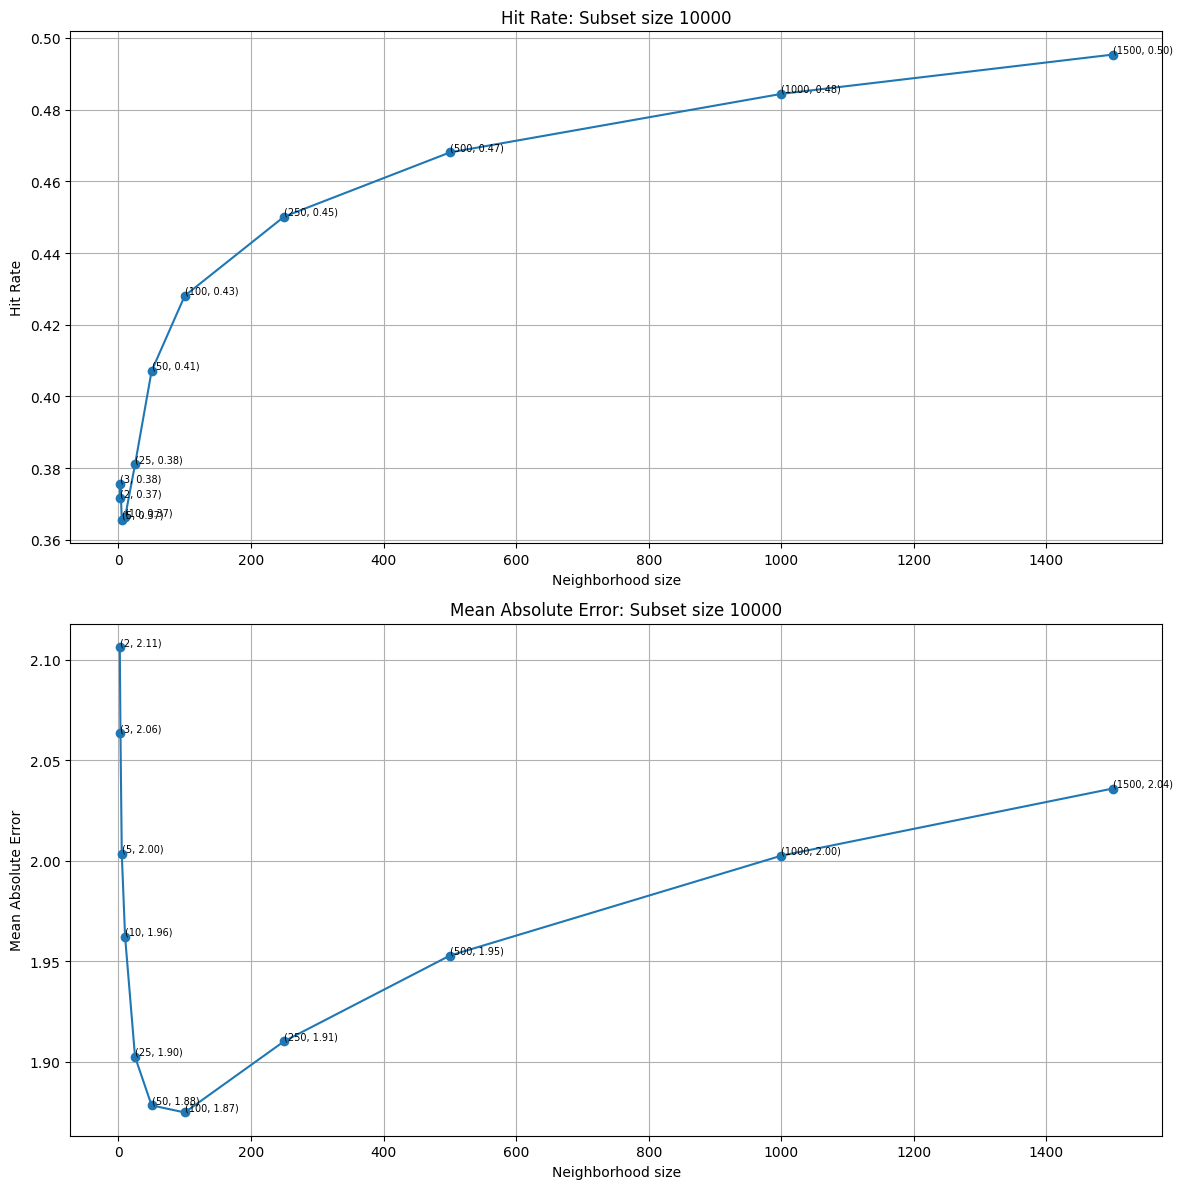

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

labels=['Hit Rate', 'Mean Absolute Error']
index_num = [3, 2]
for axnum, ax in enumerate(axs.flatten()):
    index = index_num[axnum]
    label = labels[axnum]
    size = subset_sizes[0]
    this_neighborhood_sizes = [s for s in neighborhood_sizes if s < size]
    
    ax.plot(this_neighborhood_sizes, [r[index] for r in results[size][3]], marker='o', label=label)
    
    for i, _ in enumerate(this_neighborhood_sizes):
        ax.text(this_neighborhood_sizes[i], results[size][3][i][index], f'({this_neighborhood_sizes[i]}, {results[size][3][i][index]:.2f})', fontsize=7, ha='left', va='bottom')
        
    ax.set_title(f'{label}: Subset size {size}')
    ax.set_xlabel('Neighborhood size')
    ax.set_ylabel(label)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [12]:
USER_SIM_FILE = 'user_similarity'
SUBSET_INDEX_MAPPING_FILE = 'subset_index_mapping'
USER_NEIGHBORHOODS_FILE = 'user_neighborhoods'

def save_model(subset_size, neighborhood_size, destination: str):
    dirname = f'saved_models/{destination}'
    os.mkdir(dirname)
    
    to_save = results[subset_size]
    
    np.save(f'{dirname}/{USER_SIM_FILE}', to_save[0])
    
    with open(f'{dirname}/{SUBSET_INDEX_MAPPING_FILE}.json', 'w') as f:
        json.dump(to_save[1], f)
    
    neighborhood = to_save[3][neighborhood_sizes.index(neighborhood_size)]
    with open(f'{dirname}/{USER_NEIGHBORHOODS_FILE}.json', 'w') as f:
        json.dump(neighborhood[0], f)
        
def load_model(source: str):
    dirname = f'saved_models/{source}'
    sims = np.load(f'{dirname}/{USER_SIM_FILE}.npy')
    
    with open(f'{dirname}/{SUBSET_INDEX_MAPPING_FILE}.json', 'r') as f:
        index_map = json.load(f)
    
    with open(f'{dirname}/{USER_NEIGHBORHOODS_FILE}.json', 'r') as f:
        neighborhoods = json.load(f)
        
    return sims, index_map, neighborhoods

In [19]:
save_model(10_000, 1500, '10k_subset')

In [21]:
taste_profile_raw['2278edda88c19b9feaadba87f4a136f5f03256b6']

[{'track': 'TRAQFGR128EF34E7AF', 'count': 1},
 {'track': 'TRAZDPO128E078ECE6', 'count': 4},
 {'track': 'TRBAMEV128F148C814', 'count': 1}]

In [ ]:
subset_index_mapping

In [17]:
class HybridCF:
    def __init__(self, user_similarity, subset_index_mapping, user_neighborhoods):
        self.user_similarity = user_similarity
        self.subset_index_mapping = subset_index_mapping
        self.user_neighborhoods = user_neighborhoods

    def predict_rating(self, user_id, track_id):
        user_index = self.subset_index_mapping[user_id]
        neighborhood = self.user_neighborhoods[user_id]
        
        neighborhood_ratings = [user_rating(neighbor, track_id) for neighbor in neighborhood]
        
        similarities = [self.user_similarity[user_index][self.subset_index_mapping[neighbor]] for neighbor in neighborhood]
        
        num = np.dot(similarities, neighborhood_ratings)
        den = np.abs(similarities).sum()
        
        if num == 0 or den == 0:
            return 0

        return num / den

In [18]:
model = HybridCF(*load_model('10k_subset'))